In [1]:
import pickle
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import pairwise_distances

import os
os.chdir('../Notebooks')
from clustering_evaluation import ClusterPurity
evaluator=ClusterPurity()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Load pre-trained KG model:

In [3]:
# transe_fb15k-237.pkl: pre-trained model of fb15k with 1024 dim.
with open("../dataset/transE_fb15k_256dim.pkl", "rb") as fin:
    model = pickle.load(fin)
    
entity2id = model.graph.entity2id
relation2id = model.graph.relation2id

entity_embeddings = model.solver.entity_embeddings
relation_embeddings = model.solver.relation_embeddings

entity_embeddings.shape

(14951, 256)

## Get ground-truth from FB dataset:

In [4]:
fb_train=pd.read_csv('../dataset/Release/train.txt', sep='\t', header=None, index_col=0)
fb_valid=pd.read_csv('../dataset/Release/valid.txt', sep='\t', header=None, index_col=0)
fb_test=pd.read_csv('../dataset/Release/test.txt', sep='\t', header=None, index_col=0)

fb_df=pd.concat([fb_train, fb_valid, fb_test])
fb_df['type']= fb_df[1].apply(lambda x: x.split('/')[1])

#fb15k_OneClass = fb_df[~fb_df.index.duplicated(keep='first')] #there are entities with multiple types, we choose only the first.

In [5]:
fb_df['type']

0
/m/027rn          location
/m/017dcd               tv
/m/07s9rl0    media_common
/m/01sl1q            award
/m/0cnk2q           soccer
                  ...     
/m/0l5yl            people
/m/01z5tr           people
/m/0p5mw             music
/m/0727h          military
/m/050r1z             film
Name: type, Length: 310116, dtype: object

### Get types for FB15k entities:

In [6]:
ground_truth={}
for entity_id in entity2id.keys():
    if entity_id in fb_df.index:
        if isinstance(fb_df.loc[entity_id, 'type'], pd.core.series.Series): 
            ground_truth[entity_id]=fb_df.loc[entity_id, 'type'][0]
        else:
            ground_truth[entity_id]=fb_df.loc[entity_id, 'type']
    else:
        ground_truth[entity_id]='unknown' # for missed types

In [7]:
# count frequent types in ground_truth
from collections import Counter
Counter(ground_truth.values()).most_common()


[('award', 2552),
 ('people', 2184),
 ('film', 2158),
 ('location', 1472),
 ('unknown', 1060),
 ('music', 767),
 ('soccer', 693),
 ('common', 618),
 ('education', 617),
 ('base', 611),
 ('sports', 434),
 ('tv', 325),
 ('organization', 317),
 ('user', 161),
 ('business', 146),
 ('olympics', 137),
 ('government', 135),
 ('influence', 118),
 ('military', 67),
 ('media_common', 64),
 ('medicine', 55),
 ('language', 51),
 ('time', 43),
 ('travel', 42),
 ('dataworld', 28),
 ('ice_hockey', 28),
 ('food', 22),
 ('celebrities', 20),
 ('american_football', 18),
 ('baseball', 5),
 ('broadcast', 3)]

In [8]:
#filter top commen types
entity_embedding_filter=[]
y_true_filter=[]

top_types=['award', 'people', 'film', 'location', 'music', 'soccer', 'education']

for k, value in ground_truth.items():
    if value in top_types:        
        entity_embedding_filter.append(entity_embeddings[entity2id[k]])
        y_true_filter.append(value)

In [9]:
entity_embedding_filter=np.asarray(entity_embedding_filter)
entity_embedding_filter.shape

(10443, 256)

In [10]:
le =LabelEncoder()
y_encoded=le.fit_transform(y_true_filter)
labels=le.classes_.tolist()

# Split data: train-test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(entity_embedding_filter, y_encoded, test_size=0.33, random_state=42)

## t-SNE Freebase visualization

In [13]:
# plotting the data before clustering:
projection_full = TSNE(random_state=42).fit_transform(entity_embedding_filter)
projection_train = TSNE(random_state=42).fit_transform(X_train)
projection_test = TSNE(random_state=42).fit_transform(X_test)

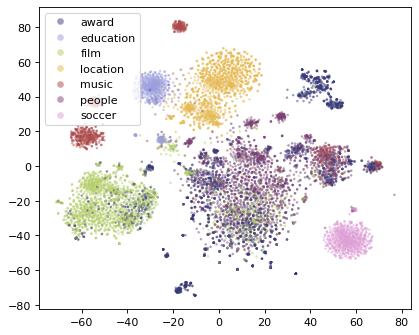

In [21]:
plt.figure(figsize=(6, 5), dpi=80)
scatter=plt.scatter(projection_full[:,0], projection_full[:,1], s=5,  cmap='tab20b', c=y_encoded, linewidth=0, alpha=0.5) 

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)

plt.savefig('./fb15k-transE-full.pdf', dpi=100)

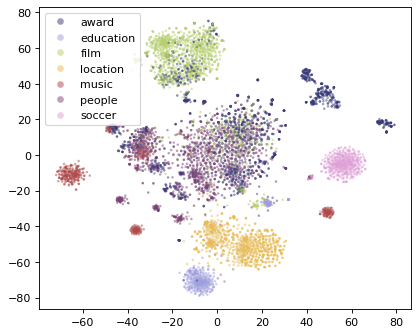

In [19]:
plt.figure(figsize=(6, 5), dpi=80)
scatter=plt.scatter(projection_train[:,0], projection_train[:,1], s=5,  cmap='tab20b', c=y_train, linewidth=0, alpha=0.5) 

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)

plt.savefig('./fb15k-transE-full.pdf', dpi=100)

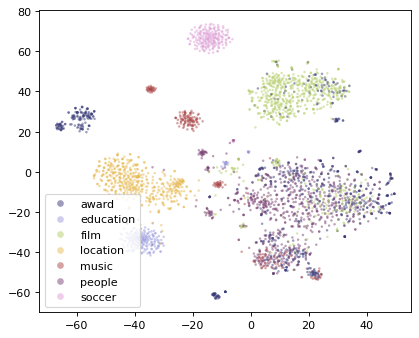

In [20]:
plt.figure(figsize=(6, 5), dpi=80)
scatter=plt.scatter(projection_test[:,0], projection_test[:,1], s=5,  cmap='tab20b', c=y_test, linewidth=0, alpha=0.5) 

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)

plt.savefig('./fb15k-transE-full.pdf', dpi=100)

## Density-based Embeddings:

## HDBSCAN:

In [22]:
import hdbscan

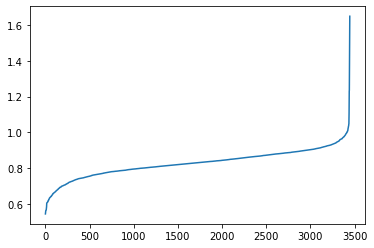

In [23]:
# final optimal value for cluster epsilon
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X_test)
distances, indices = nbrs.kneighbors(X_test)

distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)

In [24]:
X_train=X_train.astype(np.double)

In [38]:
hdbscan_clusterer=hdbscan.HDBSCAN(algorithm='best', alpha=0.5, metric='precomputed', cluster_selection_method='leaf',
                                      min_samples=3, min_cluster_size=400, core_dist_n_jobs=-1,allow_single_cluster=True,
                                      cluster_selection_epsilon=0.9)

distance_matrix = pairwise_distances(X_train, metric='cosine')
hdbscan_clusterer.fit(distance_matrix)

ytrain_labels=hdbscan_clusterer.labels_

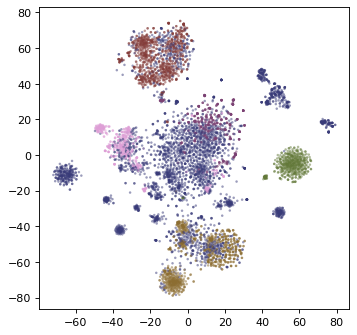

In [39]:
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(*projection_train.T,s=5,  cmap='tab20b', c=ytrain_labels, linewidth=0, alpha=0.5) 

### Evaluation

#### Results of train dataset:

In [40]:
    #----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_train, ytrain_labels)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_train, ytrain_labels, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_train, ytrain_labels, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_train, ytrain_labels, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_train, y_pred=ytrain_labels))

Accuracy: 0.171527
Precision: 0.199021
Recall: 0.171527
F1 score: 0.175915
Purity:  0.5255860491709549


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Results for test dataset:

In [ ]:
X_test=X_test.astype(np.double)

In [42]:
distance_matrix = pairwise_distances(X_test, metric='cosine')
hdbscan_clusterer.fit(distance_matrix)
ytest_labels=hdbscan_clusterer.labels_

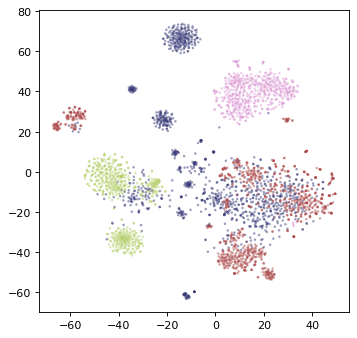

In [43]:
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(*projection_test.T,s=5,  cmap='tab20b', c=ytest_labels, linewidth=0, alpha=0.5) 

In [44]:
    #----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, ytest_labels)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, ytest_labels, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, ytest_labels, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, ytest_labels, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_test, y_pred=ytest_labels))

Accuracy: 0.155788
Precision: 0.186073
Recall: 0.155788
F1 score: 0.169588
Purity:  0.5691906005221932


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Centroid-based Clustering (K-means):

In [46]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7).fit(X_train)
y_kmeans=kmeans.predict(X_test)

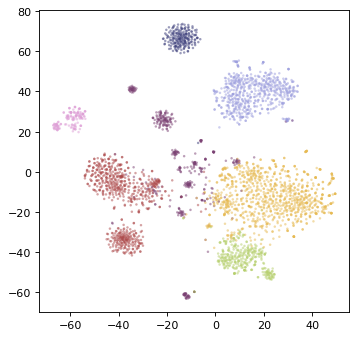

In [47]:
plt.figure(figsize=(5, 5), dpi=80)

plt.scatter(*projection_test.T,s=5,  cmap='tab20b', c=y_kmeans, linewidth=0, alpha=0.5) 

In [48]:
    #----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_kmeans)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_kmeans, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_kmeans, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_kmeans, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_test, y_pred=y_kmeans))

Accuracy: 0.029591
Precision: 0.055930
Recall: 0.029591
F1 score: 0.038691
Purity:  0.6318537859007833


## Agglomerative Clustering:

In [49]:
from sklearn.cluster import AgglomerativeClustering
aggClustering = AgglomerativeClustering(n_clusters=7).fit(X_train)
y_aggClustering=aggClustering.fit_predict(X_test)

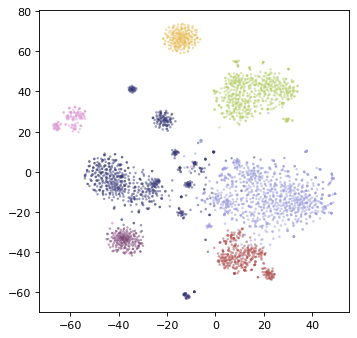

In [50]:
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(*projection_test.T,s=5, cmap='tab20b', c=y_aggClustering, linewidth=0, alpha=0.5) 

In [51]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_aggClustering)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_aggClustering, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_aggClustering, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_aggClustering, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_test, y_pred=y_aggClustering))

Accuracy: 0.187699
Precision: 0.207498
Recall: 0.187699
F1 score: 0.195939
Purity:  0.6504206556425878


# Supervised Baselines:

## Logistic Regression:

In [52]:
from sklearn.linear_model import LogisticRegression

logistic_clf = LogisticRegression(solver='liblinear',random_state=42).fit(X_train, y_train.ravel())
y_lr = logistic_clf.predict(X_test)

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_lr)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_lr, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_lr, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_lr, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_lr))

Accuracy: 0.771105
Precision: 0.783415
Recall: 0.771105
F1 score: 0.774066
Purity Score:  0.7711053089643168


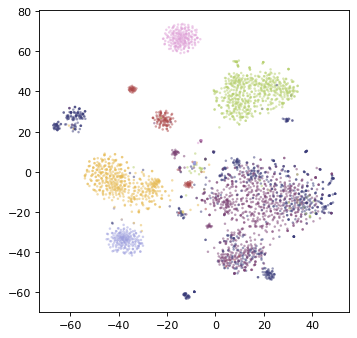

In [53]:
plt.figure(figsize=(5, 5), dpi=80)

plt.scatter(*projection_test.T,s=5,  cmap='tab20b', c=y_lr, linewidth=0, alpha=0.5) 

## KNN:

In [54]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train.ravel())
y_knn = neigh.predict(X_test)

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_knn)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_knn, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_knn, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_knn, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_knn))

Accuracy: 0.726719
Precision: 0.728635
Recall: 0.726719
F1 score: 0.725476
Purity Score:  0.7267188859878155


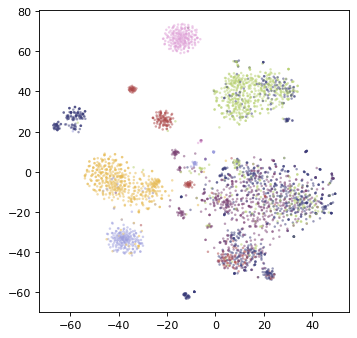

In [55]:
plt.figure(figsize=(5, 5), dpi=80)

plt.scatter(*projection_test.T,s=5,  cmap='tab20b', c=y_knn, linewidth=0, alpha=0.5) 

## RandomForest:

In [56]:
from sklearn.ensemble import RandomForestClassifier

random_clf = RandomForestClassifier(random_state=42).fit(X_train, y_train.ravel())
y_rf= random_clf.predict(X_test)

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_rf)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_rf, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_rf, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_rf, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_rf))

Accuracy: 0.783000
Precision: 0.799316
Recall: 0.783000
F1 score: 0.785924
Purity Score:  0.7829997098926603


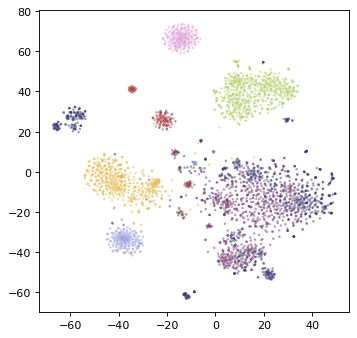

In [57]:
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(*projection_test.T,s=5,  cmap='tab20b', c=y_rf, linewidth=0, alpha=0.5) 